In [1]:
from model import *

verbose = True

# ---------------------------
# Load parameters

params = load_model_params('/config/modelconfig.jsonc')
# ---------------------------


# ---------------------------
# Real data
data_path = 'data'
dataset_name = 'MUTAG'
ret = tud_realdata(data_path,dataset_name)
gae_data = ret['dataset']
num_classes = ret['num_classes']
num_data_feats = ret['num_data_feats']
num_samples = ret['num_samples']
all_num_nodes = ret['all_num_nodes']
median_num_nodes = ret['median_num_nodes']
num_ls_feats = 21

num_train_samples = int(num_samples*params['train_ratio'])
num_val_samples = int(num_samples*params['val_ratio'])
num_miss_samples = int(num_samples*params['miss_ratio'])
num_test_samples = num_samples - num_train_samples - num_val_samples - num_miss_samples

if verbose:
    print(f'No. classes: {num_classes}')
    print(f'No. data feats.: {num_data_feats}')
    print(f'No. GAE feats.: {num_ls_feats}')
    print(f'No. samples: {num_samples}')
    print(f'Median no. nodes: {median_num_nodes}')
    print('')
# ---------------------------


# ---------------------------
gae_args = {
    'in_dim':num_ls_feats,
    'out_dim':num_ls_feats,
    'hid_dim':params['gae_hid_dim'],
    'lat_dim':params['gae_lat_dim'],
    'n_layers_enc':params['gae_n_layers'],
    'n_layers_dec':params['gae_n_layers'],
    'nonlin':torch.nn.Sigmoid,
    'batch_train_size':params['batch_train_size'],
    'batch_val_size':params['batch_val_size'],
    'lr':params['gae_lr'],
    'lmbda':params['gae_lmbda'],
    'gamma':params['gae_gamma'],
    'patience':params['gae_patience'],
    'epochs':params['gae_epochs'],
}

gnn_args = {
    "batch_train_size":params['batch_train_size'],
    "batch_val_size":params['batch_val_size'],
    "batch_test_size":params['batch_test_size'],
    "num_feats":num_data_feats,
    "num_classes":num_classes,
    "num_hid":params['gnn_hid_dim'],
    "lr":params['gnn_lr'],
    "lmbda":params['gnn_lmbda'],
    "gamma":params['gnn_gamma'],
    "patience":params['gnn_patience'],
    "epochs":params['gnn_epochs'],
}
# ---------------------------


# ---------------------------
# Train models for graph classification
exp_list = []

for i_trial in range(params['num_trials']):
    if verbose:
        print(f"Trial {i_trial+1} of {params['num_trials']}")

    shuff_inds = np.random.permutation(num_samples)
    gae_train_data = list(map(lambda i:gae_data[i],shuff_inds[:num_train_samples]))
    gae_miss_data = list(map(lambda i:gae_data[i],shuff_inds[num_train_samples:num_train_samples+num_miss_samples]))
    gae_val_data = list(map(lambda i:gae_data[i],shuff_inds[num_train_samples+num_miss_samples:num_train_samples+num_miss_samples+num_val_samples]))
    gae_test_data = list(map(lambda i:gae_data[i],shuff_inds[num_test_samples:]))

    gae_exp = GAE_Experiment(gae_train_data,gae_val_data,verbose)
    gae_exp.train_model(**gae_args)

    exp_featpreds = dict(zip(params['PRED_FEAT_TYPES'],[None]*len(params['PRED_FEAT_TYPES'])))

    for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
        if PRED_FEAT_TYPE!='lse':
            gae_miss_data_pred = list(map(lambda sample:pred_node_feats_simple(sample,PRED_FEAT_TYPE,verbose),gae_miss_data))
        else:
            gae_miss_data_pred = list(map(lambda sample:pred_node_feats_lse(sample,gae_train_data,gae_exp.autoenc,params['k_graph'],params['k_node']),gae_miss_data))

        gnn_train_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_train_data + gae_miss_data_pred))
        gnn_val_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_val_data))
        gnn_test_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_test_data))

        gin_exp = GIN_Experiment(gnn_train_data,gnn_val_data,gnn_test_data,"GIN",verbose)
        gin_exp.train_model(**gnn_args)
    
        exp_featpreds[PRED_FEAT_TYPE] = ( gae_exp, gin_exp )
    
    exp_list.append( exp_featpreds )
# ---------------------------


No. classes: 2
No. data feats.: 7
No. GAE feats.: 21
No. samples: 188
Median no. nodes: 17

Trial 1 of 3
Epoch: 000 | Train loss: 9.146, Val loss: 45.766
Epoch: 100 | Train loss: 0.012, Val loss: 0.008
Epoch: 200 | Train loss: 0.093, Val loss: 0.081
Epoch: 300 | Train loss: 0.002, Val loss: 0.002
Epoch: 400 | Train loss: 0.002, Val loss: 0.001
Final: 417 | Train loss: 0.001, Val loss: 0.001



/home/vtenorio/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch: 000 | Train loss: 0.635, Val loss: 0.668, Test loss: 0.644 | Train acc: 0.671, Val acc: 0.611, Test acc: 0.665
Epoch: 040 | Train loss: 0.187, Val loss: 0.231, Test loss: 0.269 | Train acc: 0.933, Val acc: 0.833, Test acc: 0.868
Epoch: 080 | Train loss: 0.233, Val loss: 0.297, Test loss: 0.207 | Train acc: 0.899, Val acc: 0.833, Test acc: 0.910
Epoch: 120 | Train loss: 0.207, Val loss: 0.214, Test loss: 0.165 | Train acc: 0.913, Val acc: 0.889, Test acc: 0.928
Epoch: 160 | Train loss: 0.127, Val loss: 0.176, Test loss: 0.175 | Train acc: 0.960, Val acc: 0.944, Test acc: 0.946
Final: 184 | Train loss: 0.101, Val loss: 0.085, Test loss: 0.068 | Train acc: 0.960, Val acc: 0.944, Test acc: 0.970

Epoch: 000 | Train loss: 0.638, Val loss: 0.657, Test loss: 0.642 | Train acc: 0.617, Val acc: 0.611, Test acc: 0.665
Epoch: 040 | Train loss: 0.366, Val loss: 0.381, Test loss: 0.575 | Train acc: 0.846, Val acc: 0.889, Test acc: 0.814
Epoch: 080 | Train loss: 0.272, Val loss: 0.334, Test l

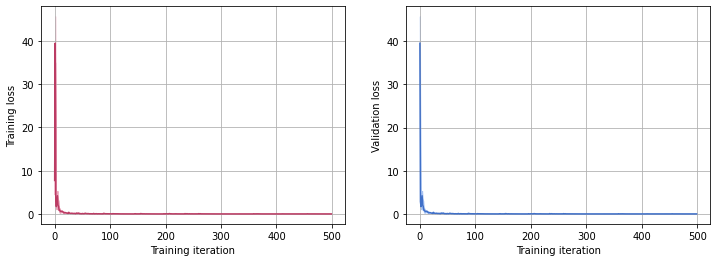

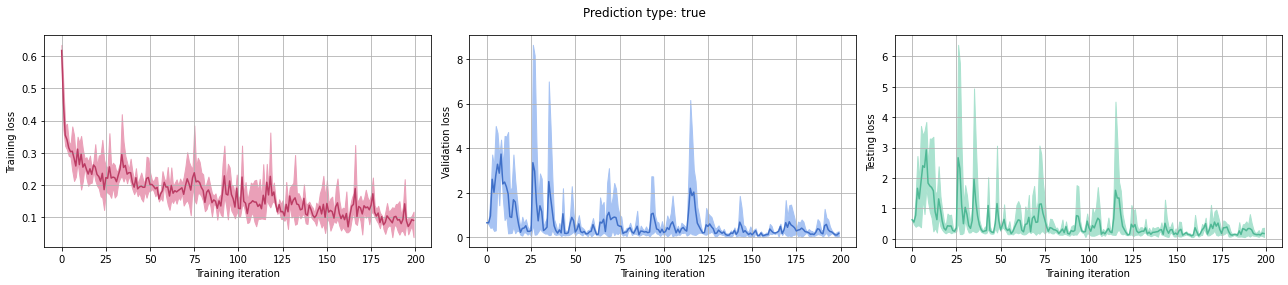

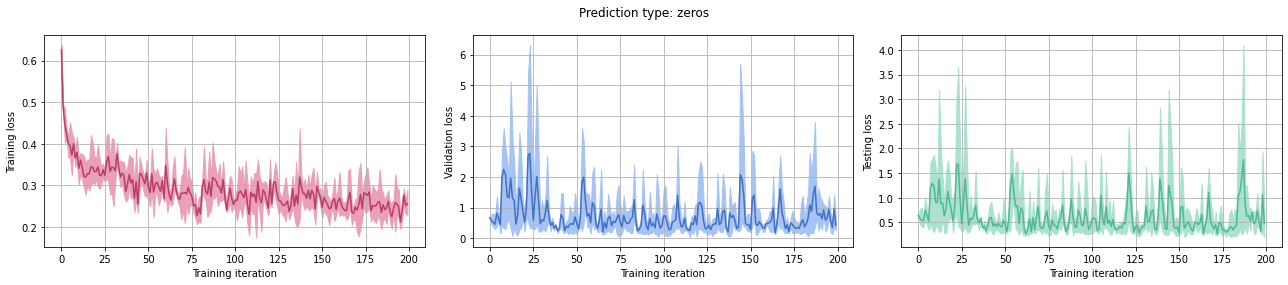

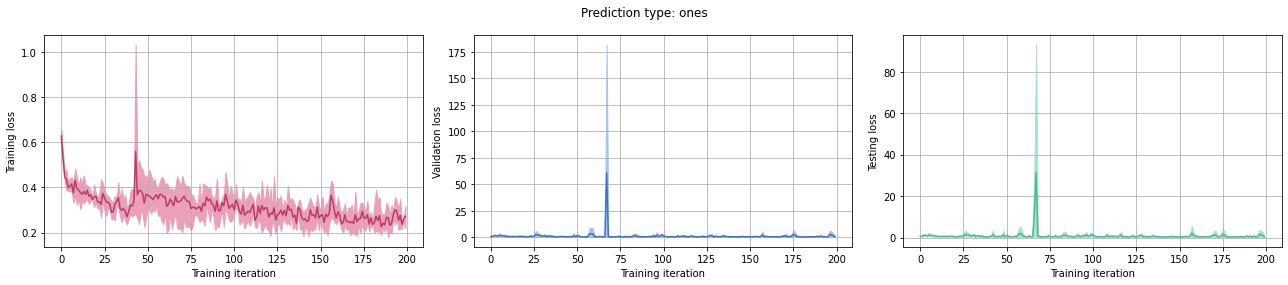

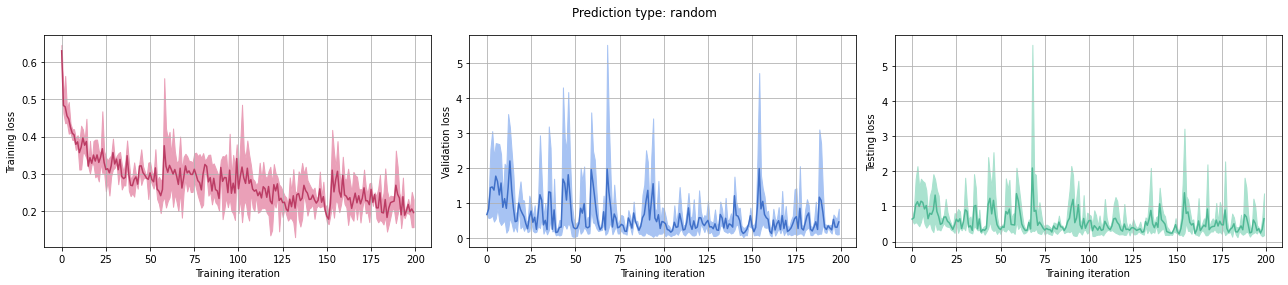

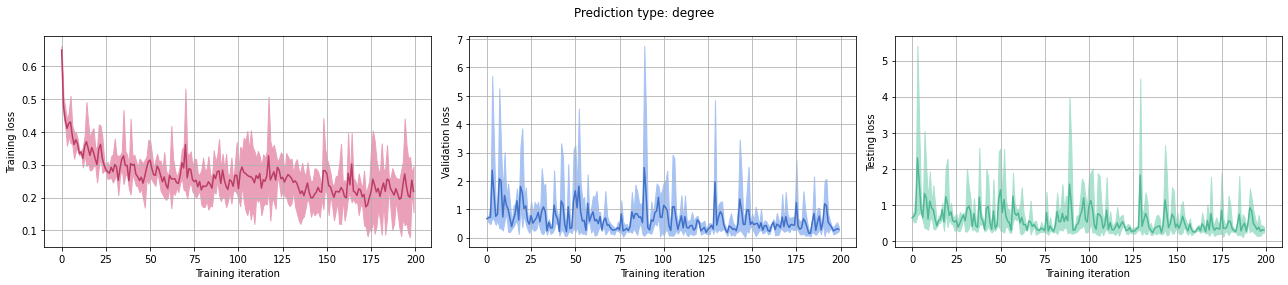

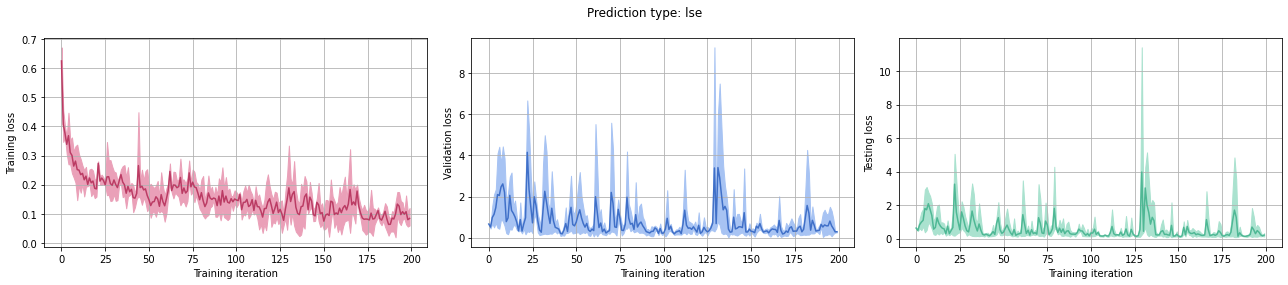

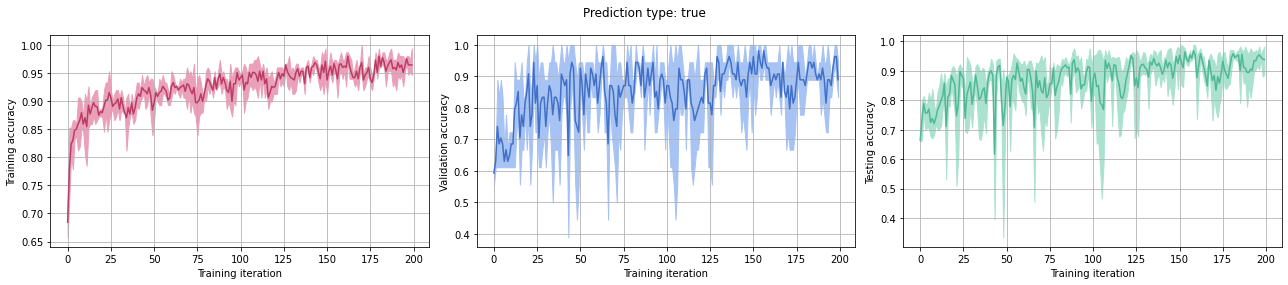

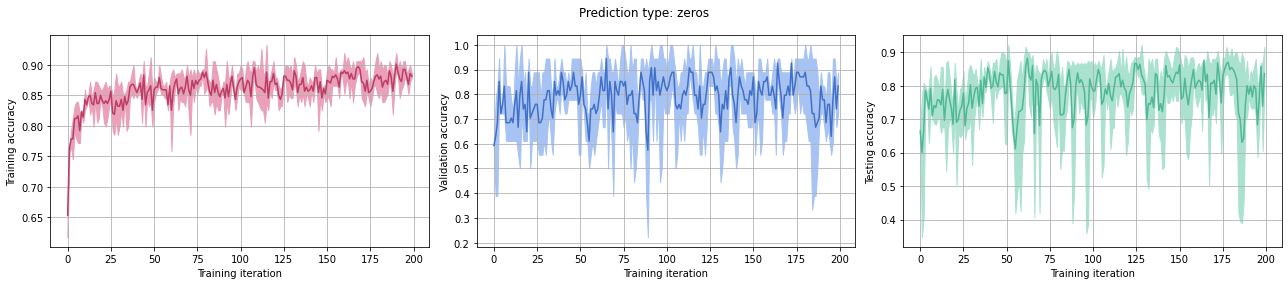

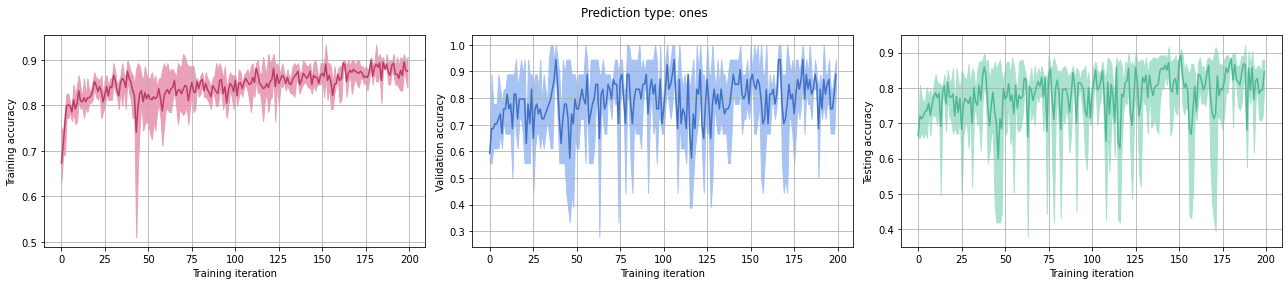

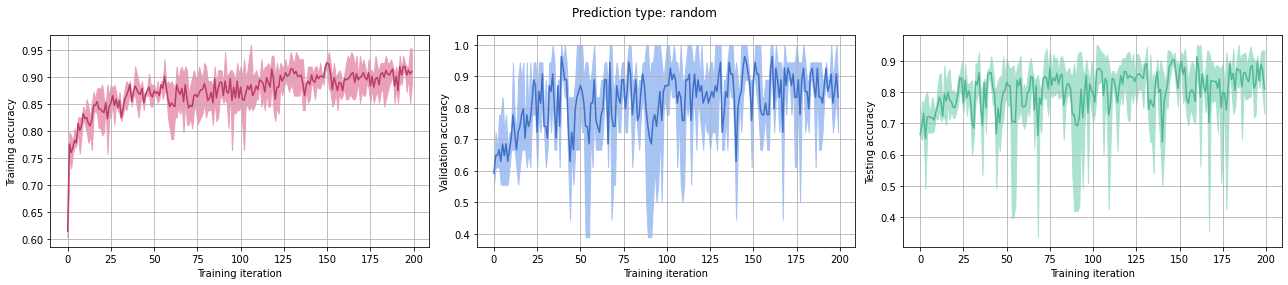

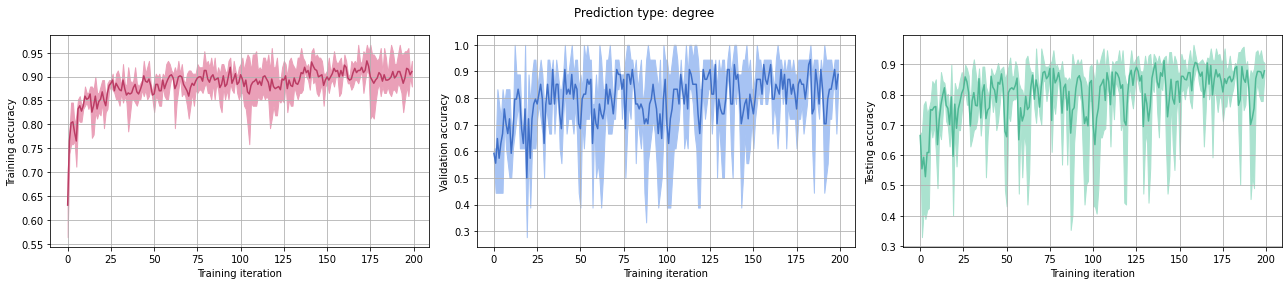

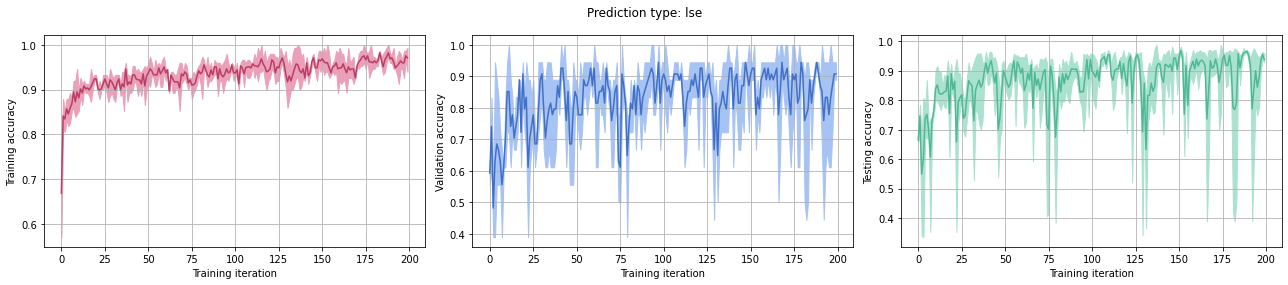

In [2]:
# Plot loss during training for GAE
gae_train_loss_avg = np.mean([exp_list[i_trial]['true'][0].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_train_loss_min = np.min([exp_list[i_trial]['true'][0].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_train_loss_max = np.max([exp_list[i_trial]['true'][0].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)

gae_val_loss_avg = np.mean([exp_list[i_trial]['true'][0].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_val_loss_min = np.min([exp_list[i_trial]['true'][0].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_val_loss_max = np.max([exp_list[i_trial]['true'][0].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)

fig = plt.figure(figsize=(2*6,4))
ax = fig.subplots(1,2)
ax[0].plot(gae_train_loss_avg,'-',c=reds[13])
ax[0].fill_between(np.arange(params['gae_epochs']),gae_train_loss_min,gae_train_loss_max,color=reds[4])
ax[0].grid(True)
ax[0].set_xlabel(f'Training iteration')
ax[0].set_ylabel(f'Training loss')
ax[1].plot(gae_val_loss_avg,'-',c=blues[12])
ax[1].fill_between(np.arange(params['gae_epochs']),gae_val_loss_min,gae_val_loss_max,color=blues[3])
ax[1].grid(True)
ax[1].set_xlabel(f'Training iteration')
ax[1].set_ylabel(f'Validation loss')

# Plot loss during training for GIN
for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
    gin_train_loss_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_loss_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_loss_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_val_loss_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_loss_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_loss_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_test_loss_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].test_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_loss_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].test_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_loss_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].test_loss_iters for i_trial in range(params['num_trials'])],axis=0)

    fig = plt.figure(figsize=(3*6,4))
    ax = fig.subplots(1,3)
    ax[0].plot(gin_train_loss_avg,'-',c=reds[13])
    ax[0].fill_between(np.arange(params['gnn_epochs']),gin_train_loss_min,gin_train_loss_max,color=reds[4])
    ax[0].grid(True)
    ax[0].set_xlabel(f'Training iteration')
    ax[0].set_ylabel(f'Training loss')
    ax[1].plot(gin_val_loss_avg,'-',c=blues[12])
    ax[1].fill_between(np.arange(params['gnn_epochs']),gin_val_loss_min,gin_val_loss_max,color=blues[3])
    ax[1].grid(True)
    ax[1].set_xlabel(f'Training iteration')
    ax[1].set_ylabel(f'Validation loss')
    ax[2].plot(gin_test_loss_avg,'-',c=greens[12])
    ax[2].fill_between(np.arange(params['gnn_epochs']),gin_test_loss_min,gin_test_loss_max,color=greens[3])
    ax[2].grid(True)
    ax[2].set_xlabel(f'Training iteration')
    ax[2].set_ylabel(f'Testing loss')
    fig.suptitle(f'Prediction type: {PRED_FEAT_TYPE}')
    fig.tight_layout()


# Plot accuracy during training for GIN
for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
    gin_train_acc_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].train_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_acc_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].train_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_acc_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].train_acc_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_val_acc_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].val_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_acc_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].val_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_acc_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].val_acc_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_test_acc_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].test_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_acc_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].test_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_acc_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].test_acc_iters for i_trial in range(params['num_trials'])],axis=0)

    fig = plt.figure(figsize=(3*6,4))
    ax = fig.subplots(1,3)
    ax[0].plot(gin_train_acc_avg,'-',c=reds[13])
    ax[0].fill_between(np.arange(params['gnn_epochs']),gin_train_acc_min,gin_train_acc_max,color=reds[4])
    ax[0].grid(True)
    ax[0].set_xlabel(f'Training iteration')
    ax[0].set_ylabel(f'Training accuracy')
    ax[1].plot(gin_val_acc_avg,'-',c=blues[12])
    ax[1].fill_between(np.arange(params['gnn_epochs']),gin_val_acc_min,gin_val_acc_max,color=blues[3])
    ax[1].grid(True)
    ax[1].set_xlabel(f'Training iteration')
    ax[1].set_ylabel(f'Validation accuracy')
    ax[2].plot(gin_test_acc_avg,'-',c=greens[12])
    ax[2].fill_between(np.arange(params['gnn_epochs']),gin_test_acc_min,gin_test_acc_max,color=greens[3])
    ax[2].grid(True)
    ax[2].set_xlabel(f'Training iteration')
    ax[2].set_ylabel(f'Testing accuracy')
    fig.suptitle(f'Prediction type: {PRED_FEAT_TYPE}')
    fig.tight_layout()

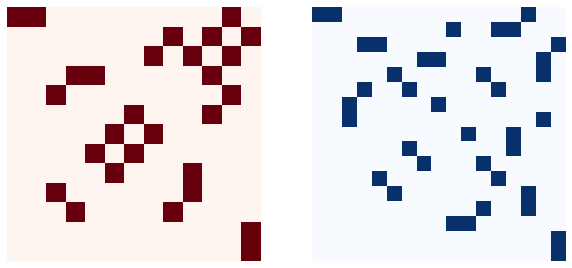

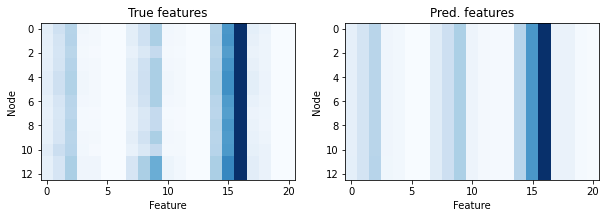

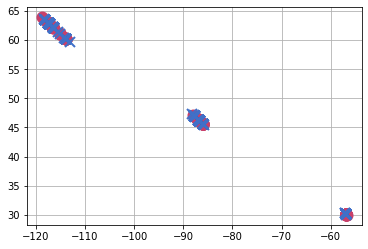

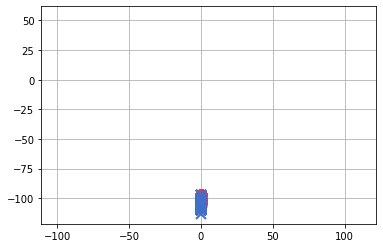

In [3]:
# Plot graphs in different classes
Y_inds = [torch.where(torch.tensor(list(map(lambda i_samp:gae_data[i_samp].Y,np.arange(num_samples))))==iy)[0] for iy in [0,1]]
i_samp = 0
cmap_per_class = ['Reds','Blues']
fig = plt.figure(figsize=(2*5,5))
ax = fig.subplots(1,2)
iy = 0
A_curr = gae_data[Y_inds[iy][i_samp]].A
sort_inds = torch.argsort(torch.sum(A_curr,axis=0))
A_curr = A_curr[sort_inds][:,sort_inds]
ax[iy].imshow(A_curr,cmap_per_class[iy],origin='lower')
ax[iy].axis('off')
iy = 1
A_curr = gae_data[Y_inds[iy][i_samp]].A
sort_inds = torch.argsort(torch.sum(A_curr,axis=0))
A_curr = A_curr[sort_inds][:,sort_inds]
ax[iy].imshow(A_curr,cmap_per_class[iy],origin='lower')
ax[iy].axis('off')

# Plot features versus predicted features for GAE
i_trial = 0
gae_curr = exp_list[i_trial]['true'][0]
F_pred = list(map(lambda i_samp:gae_curr.autoenc(gae_data[i_samp].F,gae_data[i_samp].Ah).detach().double().numpy(),np.arange(num_samples)))
F_true = list(map(lambda i_samp:gae_data[i_samp].F.double().numpy(),np.arange(num_samples)))
vmax = np.maximum(np.max(list(map(np.max,F_pred))),np.max(list(map(np.max,F_true))))
vmin = np.minimum(np.min(list(map(np.min,F_pred))),np.min(list(map(np.min,F_true))))
for i_trial in [0]:
    gae_curr = exp_list[i_trial]['true'][0]
    for i_samp in [1]:
        vmax = np.maximum(np.max(F_pred[i_samp]),np.max(F_true[i_samp]))
        vmin = np.minimum(np.min(F_pred[i_samp]),np.min(F_true[i_samp]))
        fig = plt.figure(figsize=(2*5,5))
        ax = fig.subplots(1,2)
        ax[0].imshow(gae_data[i_samp].F,mycmap)
        ax[0].set_xlabel('Feature')
        ax[0].set_ylabel('Node')
        ax[0].set_title('True features')
        ax[1].imshow(F_pred[i_samp],mycmap,vmin=vmin,vmax=vmax)
        ax[1].set_xlabel('Feature')
        ax[1].set_ylabel('Node')
        ax[1].set_title('Pred. features')

# Plot latent node and graph embeddings in different classes for GAE
i_trial = 0
gae_curr = exp_list[i_trial]['true'][0]

Z = list(map(lambda i_samp:gae_curr.autoenc.encode(gae_data[i_samp].F,gae_data[i_samp].Ah).detach().double().numpy(),np.arange(num_samples)))
Y_inds = [torch.where(torch.tensor(list(map(lambda i_samp:gae_data[i_samp].Y,np.arange(num_samples))))==iy)[0] for iy in [0,1]]
Z_per_class = [list(map(lambda i_samp:Z[i_samp],Y_inds[iy])) for iy in [0,1]]

mkrs_per_class = ['o','x']
clrs_per_class = [reds[12],blues[12]]
plt_args = {
    'markersize':10,
    'linewidth':3,
    'markeredgewidth':2
}

# Plot latent node embeddings
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
for iy in [0,1]:
    # for i_samp in range(len(Y_inds[iy])):
    for i_samp in range(10):
        ax.plot(Z_per_class[iy][i_samp][:,0],Z_per_class[iy][i_samp][:,1],mkrs_per_class[iy],c=clrs_per_class[iy],**plt_args)

# Plot latent graph embeddings
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
for iy in [0,1]:
    for i_samp in range(len(Y_inds[iy])):
        ax.plot(*np.mean(Z_per_class[iy][i_samp],axis=0),mkrs_per_class[iy],c=clrs_per_class[iy],**plt_args)



# Exhaustive experiments with several datasets

In [4]:
exp_list = {}

datasets = ["MUTAG", "PROTEINS", 'NCI1'] # "AIDS", 'ENZYMES'

for d, dataset_name in enumerate(datasets):

    print("**************************************")
    print(f"Starting with dataset {dataset_name}")
    print("**************************************")

    ret = tud_realdata(data_path,dataset_name)
    gae_data = ret['dataset']
    num_classes = ret['num_classes']
    num_data_feats = ret['num_data_feats']
    num_samples = ret['num_samples']
    all_num_nodes = ret['all_num_nodes']
    median_num_nodes = ret['median_num_nodes']
    num_ls_feats = 21

    num_train_samples = int(num_samples*params['train_ratio'])
    num_val_samples = int(num_samples*params['val_ratio'])
    num_miss_samples = int(num_samples*params['miss_ratio'])
    num_test_samples = num_samples - num_train_samples - num_val_samples - num_miss_samples

    gnn_args["num_feats"] = num_data_feats
    gnn_args["num_classes"] = num_classes

    exp_list[dataset_name] = []

    for i_trial in range(params['num_trials']):
        if verbose:
            print(f"Trial {i_trial+1} of {params['num_trials']}")

        shuff_inds = np.random.permutation(num_samples)
        gae_train_data = list(map(lambda i:gae_data[i],shuff_inds[:num_train_samples]))
        gae_miss_data = list(map(lambda i:gae_data[i],shuff_inds[num_train_samples:num_train_samples+num_miss_samples]))
        gae_val_data = list(map(lambda i:gae_data[i],shuff_inds[num_train_samples+num_miss_samples:num_train_samples+num_miss_samples+num_val_samples]))
        gae_test_data = list(map(lambda i:gae_data[i],shuff_inds[num_test_samples:]))

        if verbose:
            print("Training GAE")
        gae_exp = GAE_Experiment(gae_train_data,gae_val_data,verbose)
        gae_exp.train_model(**gae_args)

        exp_featpreds = dict(zip(params['PRED_FEAT_TYPES'],[None]*len(params['PRED_FEAT_TYPES'])))

        for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
            if verbose:
                print(f" Feat {PRED_FEAT_TYPE}")
            if PRED_FEAT_TYPE!='lse':
                gae_miss_data_pred = list(map(lambda sample:pred_node_feats_simple(sample,PRED_FEAT_TYPE,verbose),gae_miss_data))
            else:
                gae_miss_data_pred = list(map(lambda sample:pred_node_feats_lse(sample,gae_train_data,gae_exp.autoenc,params['k_graph'],params['k_node']),gae_miss_data))

            gnn_train_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_train_data + gae_miss_data_pred))
            gnn_val_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_val_data))
            gnn_test_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_test_data))

            gin_exp = GIN_Experiment(gnn_train_data,gnn_val_data,gnn_test_data,"GIN",verbose)
            gin_exp.train_model(**gnn_args)

            mlp_exp = GIN_Experiment(gnn_train_data,gnn_val_data,gnn_test_data,"MLP",verbose)
            mlp_exp.train_model(**gnn_args)
        
            exp_featpreds[PRED_FEAT_TYPE] = ( gae_exp, gin_exp, mlp_exp )
        
        exp_list[dataset_name].append( exp_featpreds )
    # ---------------------------

**************************************
Starting with dataset MUTAG
**************************************
Trial 1 of 3
Training GAE
Epoch: 000 | Train loss: 5.429, Val loss: 26.874
Epoch: 100 | Train loss: 0.053, Val loss: 0.052
Epoch: 200 | Train loss: 0.005, Val loss: 0.004
Epoch: 300 | Train loss: 0.011, Val loss: 0.005
Epoch: 400 | Train loss: 0.001, Val loss: 0.001
Final: 499 | Train loss: 0.001, Val loss: 0.001

 Feat true
Epoch: 000 | Train loss: 0.667, Val loss: 0.584, Test loss: 0.633 | Train acc: 0.544, Val acc: 0.778, Test acc: 0.665
Epoch: 040 | Train loss: 0.186, Val loss: 1.122, Test loss: 0.330 | Train acc: 0.906, Val acc: 0.556, Test acc: 0.874
Epoch: 080 | Train loss: 0.151, Val loss: 0.528, Test loss: 0.838 | Train acc: 0.926, Val acc: 0.778, Test acc: 0.826
Epoch: 120 | Train loss: 0.117, Val loss: 0.983, Test loss: 0.265 | Train acc: 0.946, Val acc: 0.722, Test acc: 0.898
Epoch: 160 | Train loss: 0.113, Val loss: 1.526, Test loss: 0.348 | Train acc: 0.960, Val acc: 

In [5]:
[exp_list['MUTAG'][i_trial][PRED_FEAT_TYPE][1].test_pred_acc for i_trial in range(params['num_trials'])]

[0.7844311377245509, 0.8922155688622755, 0.9041916167664671]

In [6]:
exp_list['MUTAG'][0]['true'][2].test_pred_acc

0.7305389221556886

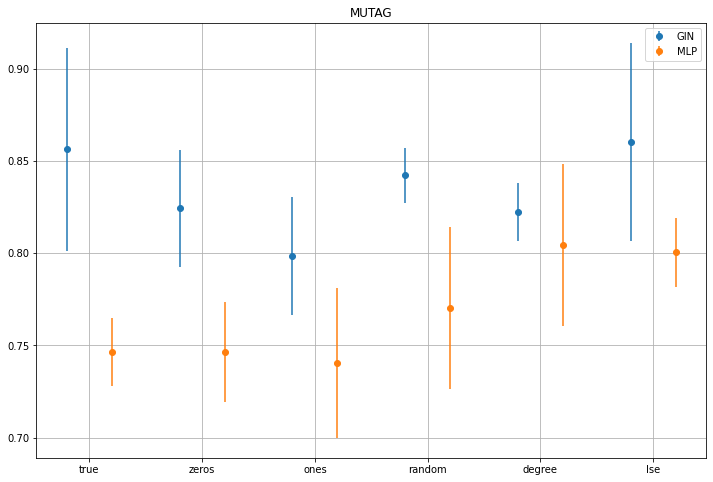

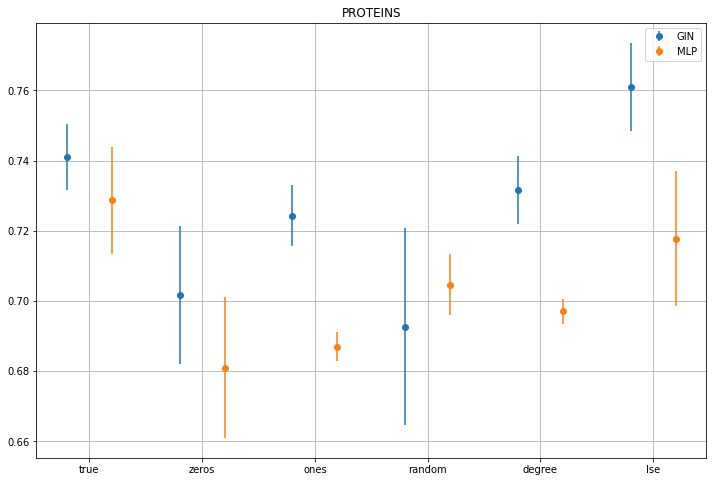

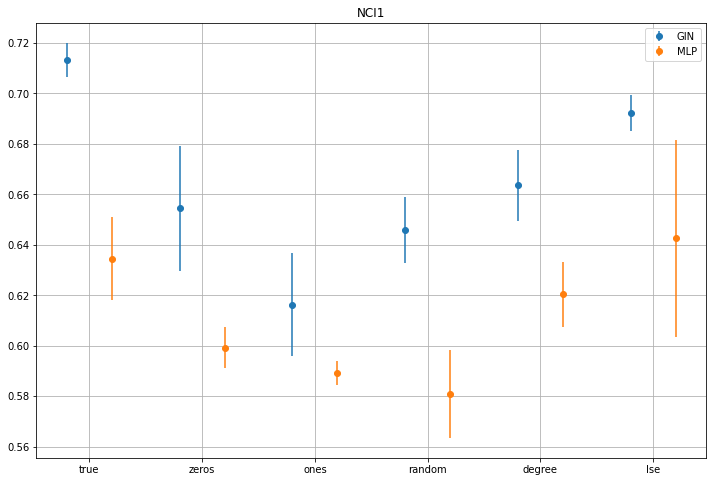

In [10]:
n_feats = len(params['PRED_FEAT_TYPES'])

for k, v in exp_list.items():
    f = plt.figure(figsize=(12,8))

    gin_test_acc_avg, gin_test_acc_std, \
        mlp_test_acc_avg, mlp_test_acc_std \
             = [np.zeros(n_feats) for _ in range(4)]
    for i in range(n_feats):
    
        gin_test_acc_avg[i] = np.mean([v[i_trial][params['PRED_FEAT_TYPES'][i]][1].test_pred_acc for i_trial in range(params['num_trials'])])
        gin_test_acc_std[i] = np.std([v[i_trial][params['PRED_FEAT_TYPES'][i]][1].test_pred_acc for i_trial in range(params['num_trials'])])

        mlp_test_acc_avg[i] = np.mean([v[i_trial][params['PRED_FEAT_TYPES'][i]][2].test_pred_acc for i_trial in range(params['num_trials'])])
        mlp_test_acc_std[i] = np.std([v[i_trial][params['PRED_FEAT_TYPES'][i]][2].test_pred_acc for i_trial in range(params['num_trials'])])

    plt.errorbar(np.arange(n_feats)-0.2, gin_test_acc_avg, gin_test_acc_std, linestyle='None', marker='o', label='GIN')
    plt.errorbar(np.arange(n_feats)+0.2, mlp_test_acc_avg, mlp_test_acc_std, linestyle='None', marker='o', label='MLP')

    plt.grid()
    plt.legend()

    plt.title(k)

    plt.xticks(np.arange(n_feats), params['PRED_FEAT_TYPES'])